# FODO cell with self-consistent space charge around the 90deg stop-band

Corresponding to case 013: `sixtracklib_pyht_playground/fodo_sc/013_bunch_fast-sync-motion_3D-PIC_many-thin-magnet-slices/013_FODO_SC_fast-sync-mot_3D.ipynb`

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

Particular packages needed:

- `cpymad`: https://pypi.org/project/cpymad/
- `PyHEADTAIL`: https://github.com/PyCOMPLETE/PyHEADTAIL (run the python3 script to generate the py3 version)

In [2]:
from cpymad.madx import Madx

In [3]:
from scipy.constants import e, m_p, c, epsilon_0

In [4]:
import sys, os
sys.path = ["/home/oeftiger/gsi/git/python3/PyHEADTAIL/"] + sys.path

In [5]:
from PyHEADTAIL.particles import generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5





# Beam Parameters

Define basic beam parameters:

In [6]:
n_macroparticles = int(1e6)
n_sc_nodes = 10

intensity = 8.846e9 # number of particles represented by the beam
epsn_x = 1e-6 # normalised RMS emittance in [m.rad]
epsn_y = 1e-6 # normalised RMS emittance in [m.rad]
epsg_z = 3.13e-05 # longitudinal 4RMS emittance in [eV.s]
sigma_tau = 6.3e-10 # bunch length in [s]

Ekin = 10e6 # in eV
circumference = 1 # period length in [m]

# transverse tunes (number of oscillations per FODO period)
# --> determine quadrupole strengths
Qx = 92./360
Qy = Qx
# longitudinal tune --> determines RF voltage
Qs = 9.2/360. 

Compute other quantities:

In [7]:
p0c = np.sqrt(Ekin**2 + 2*Ekin*m_p/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (m_p * c))**2)
beta = np.sqrt(1 - gamma**-2)
epsg_x = epsn_x / (beta * gamma)
epsg_y = epsn_y / (beta * gamma)
epsn_z = epsg_z / (beta * gamma)
bunch_length = 4 * sigma_tau
sigma_z = beta * c * bunch_length / 4. # in [m]

eta = -gamma**-2
rf_voltage = 2 * np.pi * p0 * beta * c * Qs**2 / (e * 1 * -eta)
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

sigma_dp = sigma_z / beta_z

# Set up FODO cell in MAD-X

In [8]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.09.19 11:23:23      +
  ++++++++++++++++++++++++++++++++++++++++++++


Here is the lattice definition: `kqd` and `kqf` will be the quadrupole strengths (for a length $l$ quadrupole), they define the magnetic field strength via $$k_{q}\cdot l = \frac{1}{B\rho}\frac{\partial B_y}{\partial x} = \frac{1}{B\rho}\frac{\partial B_x}{\partial y} .$$

(The magnetic rigidity $B\rho=p_0/e$ relates to the beam momentum $p_0=\beta\gamma m_p c$ devided by its charge.)

We have
- half a defocusing quadrupole at 0m of length 0.05m, then
- an RF cavity at 0.25m, then
- a focusing quadrupole at 0.5m of length 0.1m, then 
- another RF cavity at 0.75m, and finally
- half a defocusing quadrupole at 0.95m of length 0.05m.

Like this the lattice is symmetric.

In [9]:
madx.input('''
kqd := -30.9217;
kqf := 30.9217;
v := 0;

qd: quadrupole, l = 0.05, k1 := kqd;
qf: quadrupole, l = 0.1, k1 := kqf;
rf: rfcavity, volt := v, harmon = 1, lag = 0;
'''
+
'''
fodo: sequence, l = {0};
qd, at = 0.025;
rf, at = {0} / 4.;
qf, at = {0} / 2.;
rf, at = {0} * 3 / 4.;
qd, at = {0} - 0.025;
endsequence;
'''.format(circumference))

True

Taking a proton beam at 10MeV kinetic energy:

In [10]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [11]:
madx.use(sequence='fodo')

Now we find correct values of `kqd` and `kqf` to yield the transverse betatron tunes $Q_x, Q_y$ as defined above.

In [12]:
madx.input(
'''match, sequence=fodo;
global, sequence=fodo, q1={Qx}, q2={Qy};
vary, name = kqd, step=0.0001;
vary, name = kqf, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
'''.format(Qx=Qx, Qy=Qy))

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.67936573e-25





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqd                      -3.09217e+01 -3.09217e+01 -1.00000e+20  1.00000e+20
kqf                       3.09217e+01  3.09217e+01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.67936573e-25


True

Splitting up the thick quadrupoles into thin delta-like kicks with drifts in between (such that they become mere matrix multiplications):

In [13]:
assert madx.command.select(
    flag='MAKETHIN',
    CLASS='qd',
    SLICE='8',
)
assert madx.command.select(
    flag='MAKETHIN',
    CLASS='qf',
    SLICE='16',
)

madx.command.makethin(
    makedipedge=False,
    style='teapot',
    sequence='FODO',
)

makethin: style chosen : teapot
makethin: slicing sequence : fodo


True

# Add space charge placeholders

Every 10cm we place a space charge node to compute the self-field interaction of the beam:

In [14]:
madx.input('sc_placeholder: Marker;')

madx.command.seqedit(sequence='FODO')
for s_sc in np.linspace(start=0, stop=circumference, num=n_sc_nodes, endpoint=False):
    madx.command.install(element='sc_placeholder', at=s_sc)
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  10
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

Compute the lattice properties with `MAD-X`, verifying that `q1` and `q2` give the betatron tunes we aim for:

In [15]:
madx.use(sequence='fodo')

twiss = madx.twiss()
assert circumference == twiss['s'][-1]

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                 1                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
      0.2555524323       -2.273554065        1.677764673                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2555540499 

               dq2            betymax              dymax              dyrms 
       -2.27358879        1.678284422                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [16]:
print ('relative tune error in x: {:.6f}% and y: {:.6f}%'.format(
    (twiss.summary['q1'] - Qx) / Qx * 100, (twiss.summary['q2'] - Qy) / Qy * 100))

relative tune error in x: -0.001222% and y: -0.000589%


And the lattice optics now yield along the path length $s$:

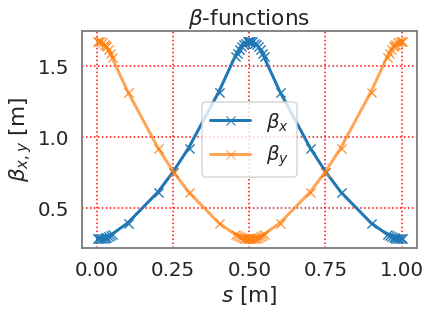

In [17]:
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y$', alpha=0.7)
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.xlabel('$s$ [m]')
plt.legend()

# switch on synchrotron motion

In [18]:
madx.input('v := {}'.format(0.5 * rf_voltage * 1e-6)) # in MV --> 0.5x because there are 2 cavities

++++++ info: v redefined


True

# Preparing PyHEADTAIL beam

Creating the beam distribution:

In [19]:
# dispersion should be zero as we don't have dipoles
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generators.generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z,
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
    limit_n_rms_x=3.4**2, limit_n_rms_y=3.4**2, limit_n_rms_z=3.4**2,
)

In [20]:
distribution_z_uncut = generators.gaussian2D(
    sigma_z**2)

is_accepted = generators.make_is_accepted_within_n_sigma(
    epsn_rms=sigma_z,
    limit_n_rms=3.4,
)
distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

In [21]:
z, dp = distribution_z_cut(n_macroparticles)

pyht_beam.z, pyht_beam.dp = z, dp / beta_z

match to space charge depressed bucket:

In [22]:
matched_sigma_dp = 0.496e5 / (Etot * 1e9) / beta**2 # from Ji
pyht_beam.dp *= matched_sigma_dp / pyht_beam.sigma_dp()

Plot the distribution phase space for each of the 3 planes (they have been truncated at 3.4 RMS values, indicated by the red circles in $x-x'$ space):

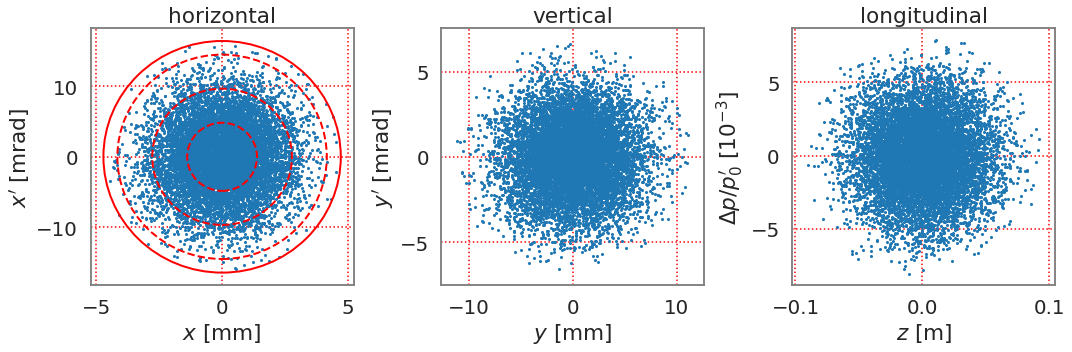

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')
plt.scatter(pyht_beam.x[::100] * 1e3, pyht_beam.xp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")

ep = mpl.patches.Ellipse(
    (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3.4*2*pyht_beam.sigma_x() * 1e3, 3.4*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='solid')
plt.gca().add_patch(ep)

plt.sca(ax[1])
plt.title('vertical')
plt.scatter(pyht_beam.y[::100] * 1e3, pyht_beam.yp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")

plt.sca(ax[2])
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0'$ [$10^{-3}$]")
plt.tight_layout()

# plt.savefig('particle_generation_phasespaces.png', dpi=150, bbox_inches='tight')

The longitudinal distribution in the unperturbed (non-space-charge-deformed) RF bucket:

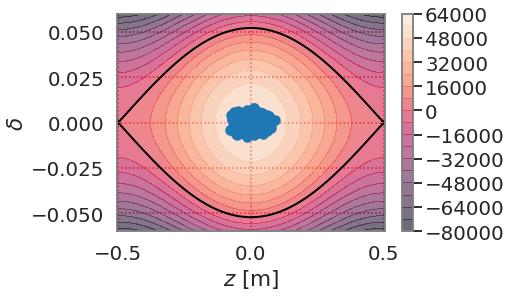

In [24]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.06, 0.06, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='black', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$\delta$');

The six coordinates are
- $x$: horizontal offset in m
- $x'$: horizontal angle (unitless) $x'\doteq p_x/p_0$ via the canonical horizontal momentum $p_x$ ($p_0=\beta\gamma m_p c$ is constant)
- $y$: vertical offset in m
- $y'$: vertical angle (unitless) [equiv. to $x'$]
- $z$: longitudinal offset of the path length position in m (head of bunch corresponds to positive $z$)
- $\delta$: longitudinal (dimensionless) momentum offset $\delta=\frac{p_z-p_0}{p_0}$ via the canonical longitudinal momentum $p_z$

They are stored in `numpy.ndarray` format:

In [25]:
pyht_beam.x

array([ 0.00247173,  0.00056069,  0.00137137, ..., -0.00111712,
        0.00122568,  0.00192216])